# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

The primary goal is to predict the price of a car accurately based on various features and market conditions.
Stakeholders: Identify key stakeholders such as car manufacturers, dealerships, and consumers who are interested in accurate car price predictions.
Business Goals: Determine specific business objectives, such as optimizing pricing strategies, improving profit margins, or enhancing the customer buying experience.

    
    Determine the specific objectives of predicting car prices. Are you interested in predicting prices for new cars, used cars, or both?
Identify the business goals and how predicting car prices can contribute to these goals, such as optimizing pricing strategies or assisting customers in making informed decisions.
1.2 Stakeholder Involvement:

Identify key stakeholders, such as automotive manufacturers, dealerships, or consumers, who have an interest in car pricing.
Understand their requirements, concerns, and expectations related to car pricing.
1.3 Business Objectives:

Establish clear, measurable business objectives. For example, you might aim to increase revenue by 10% through better pricing strategies.
    

We want to identify which factors can help us predict more acurately the prices of used cars. As part of this analysis
we want to understand if the cars from a given manufacturer sell for higher prices than similar cars(similar age, mileage and car type). Two user segments that will benefit from this analysis are
- used car dealership to stock inventory of cars
- consumers to be able to understand what a fair price for a given car should be.

In order to perform this analysis we will be analyzing the dataset of 426,000 used cars that contains attributes like year,manufacturer,model,condition,cylinders,fuel,odometer,title_status and
many other and first identify which of these attributes have a strong correlation to the price of the car.

As the next step we will build models to predict the prices of the car.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.


---




There are several categorical features, to encode these features we will be using JamesSteinEncoder from the package **category_encoders**






In [1]:
# install package category_encoders that has JamesSteinEncoder
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.3 MB/s eta 0:00:00


In [2]:
# import the required packages
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error
from sklearn.compose import make_column_transformer, make_column_selector, TransformedTargetRegressor
import scipy as sp
from sklearn.inspection import permutation_importance


As colab is being used for the assignment, mount the drive where the vehicles dataset is being stored

In [3]:
from google.colab import drive
drive.mount('/content/drive')
raw_df = pd.read_csv('/content/drive/MyDrive/assignment 2/data/vehicles.csv')

Mounted at /content/drive


In [4]:
# Do an initial visual inspection of the different columns in the dataset.
raw_df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


There are several columns with null values. Let us look at an sum of null values across the different columns.

<Figure size 1500x1000 with 0 Axes>

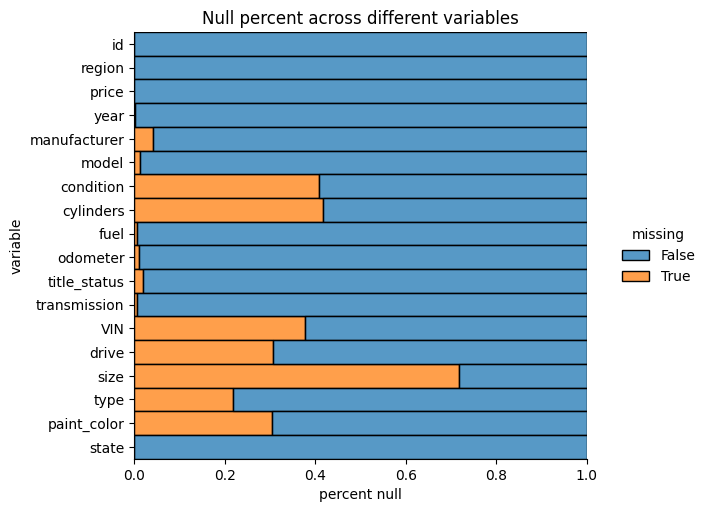

In [5]:
plt.figure(figsize=(15,10))
fig = sns.displot(
    data=raw_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
fig.set(xlabel='percent null', ylabel='variable')
plt.title("Null percent across different variables")
plt.show()

From the above it is clear that there are several columns that have null values. In particular size has null %age > 50. From analysis persepective we will drop this columns

In [6]:
# There are several columns with null values. In particular size has the largest null values. We will drop this column
# while for the other we will explore use of imputer.
#raw_df.isnull().sum().sort_values(ascending=False)

Let's force a type conversion for the different columns and look at the different columns types post this action.

In [7]:
raw_df = raw_df.convert_dtypes()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            426880 non-null  Int64 
 1   region        426880 non-null  string
 2   price         426880 non-null  Int64 
 3   year          425675 non-null  Int64 
 4   manufacturer  409234 non-null  string
 5   model         421603 non-null  string
 6   condition     252776 non-null  string
 7   cylinders     249202 non-null  string
 8   fuel          423867 non-null  string
 9   odometer      422480 non-null  Int64 
 10  title_status  418638 non-null  string
 11  transmission  424324 non-null  string
 12  VIN           265838 non-null  string
 13  drive         296313 non-null  string
 14  size          120519 non-null  string
 15  type          334022 non-null  string
 16  paint_color   296677 non-null  string
 17  state         426880 non-null  string
dtypes: Int64(4), string(14)


Let's explore the cardinality across different features.

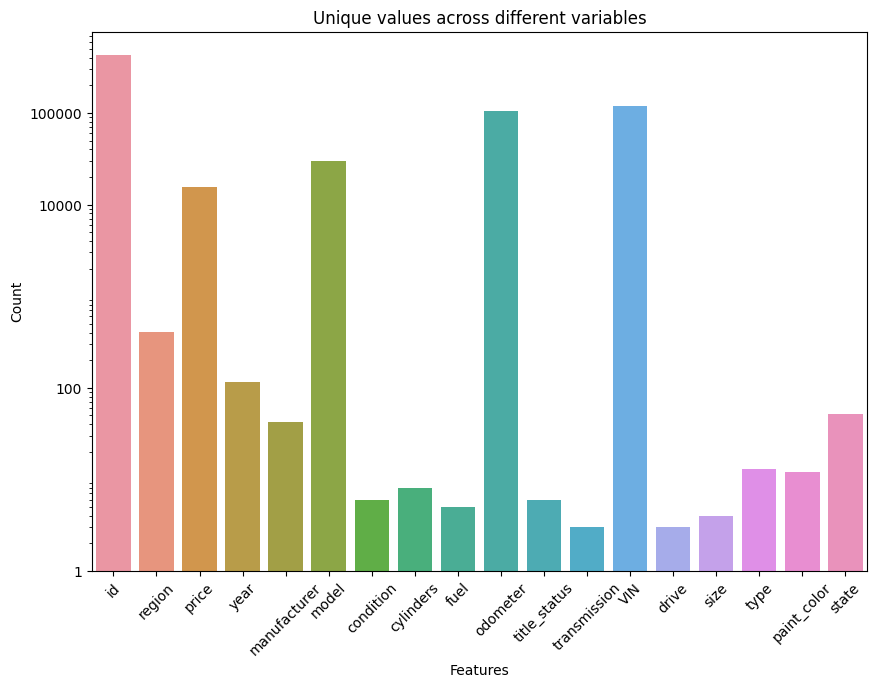

In [8]:
count_df = raw_df.nunique().reset_index()
count_df.columns = ['feature','unique_values']
count_df
plt.figure(figsize=(10,7))
g = sns.barplot(data=count_df, x='feature', y='unique_values')
g.set_yscale("log")

# the non-logarithmic labels
ticks = [1, 100, 10000, 100000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)
g.set_xticklabels(count_df['feature'], rotation=45)
plt.title("Unique values across different variables")

_ = g.set(xlabel="Features", ylabel="Count")


looking at the unique value across the different columns, ID and VIN are candidates to be removed from the dataset.


In [9]:
raw_df.nunique().reset_index()

,index,0
0,id,426880
1,region,404
2,price,15655
3,year,114
4,manufacturer,42
5,model,29649
6,condition,6
7,cylinders,8
8,fuel,5
9,odometer,104870


Let us look at the value distribution for the numeric columns.

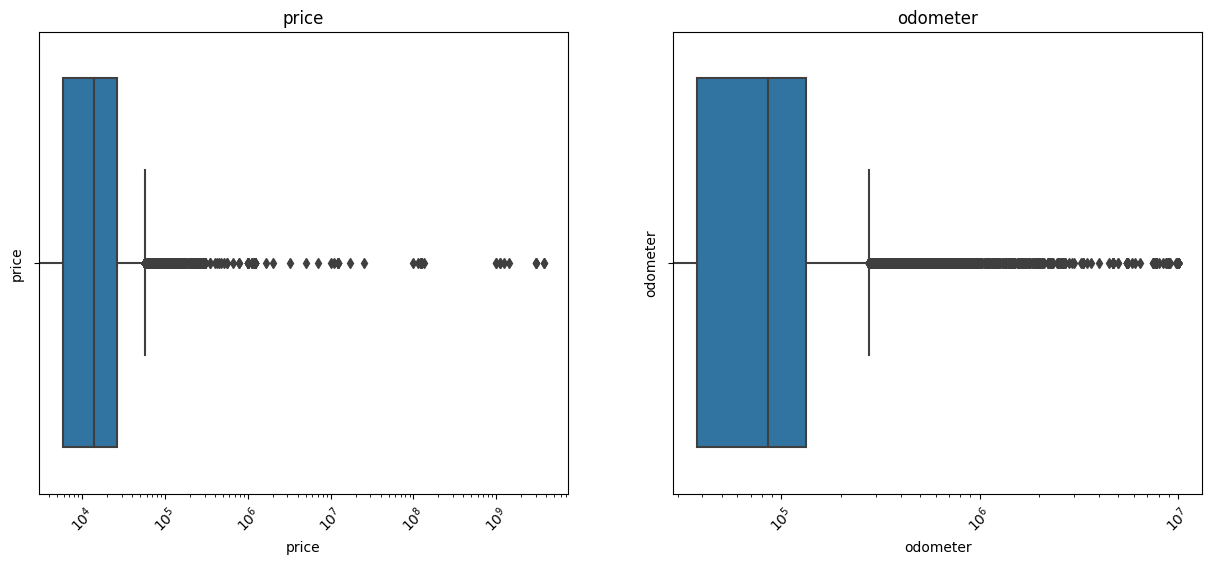

In [10]:
columns_to_plot = ['price', 'odometer']

fig, axes = plt.subplots(ncols=len(columns_to_plot), figsize=(15,6))

# Create the boxplot with Seaborn
for column, axis in zip(columns_to_plot, axes):
  filtered_data = raw_df[raw_df[column].notnull()]
  ticks = [int(x) for x in filtered_data[column].quantile(np.linspace(.1, 1, 9, 0)).values.tolist()]
  sns.boxplot(data=filtered_data, x=column, ax=axis)
  axis.set_title(column)
  axis.set_xticks(ticks)
  axis.set_xticklabels(ticks,rotation=45)

  axis.set(ylabel=column)
  axis.set_xscale("log")


plt.show()

From the above it is clear that there are some outliers for the different columns. Let us look at the same information in a tabular format

In [11]:
# when looking at the values for the integer columns we will have to remove rows with outliers. E.g a used car with a price 3.7B
# similarly odometer rating of 10M. An approach we will use is to remove the rows with values greater than p99.

raw_df.describe([.01,.1,.2,.3,.4,.5,.6,.7,.8,.9,.99])

,id,price,year,odometer
count,426880.0,426880.0,425675.0,422480.0
mean,7311486634.224333,75199.033187,2011.235191,98043.331443
std,4473170.412559,12182282.173598,9.45212,213881.500798
min,7207408119.0,0.0,1900.0,0.0
1%,7301961974.82,0.0,1967.0,2.0
10%,7304399132.1,500.0,2003.0,14939.0
20%,7307115339.2,4500.0,2007.0,30000.0
30%,7309333513.2,6995.0,2010.0,46081.0
40%,7311118470.2,9995.0,2012.0,66859.6
50%,7312620821.0,13950.0,2013.0,85548.0


In [12]:
# manually verifying the outliers in the dataset filtering cars with price > $3B, it seems like clear case of invalid data and hence removing these outliers would only improve the quality of predictions.
raw_df[ raw_df['price'] > 3000000000]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
37410,7314052904,modesto,3009548743,2021,chevrolet,<NA>,<NA>,8 cylinders,gas,1000,clean,automatic,<NA>,4wd,<NA>,<NA>,<NA>,ca
91576,7309730903,delaware,3024942282,2000,mercedes-benz,benz e320,<NA>,<NA>,gas,100000,clean,automatic,<NA>,<NA>,<NA>,<NA>,<NA>,de
257840,7309735768,south jersey,3024942282,2000,mercedes-benz,benz s430,<NA>,<NA>,gas,100000,clean,automatic,<NA>,<NA>,<NA>,<NA>,<NA>,nj
318592,7308056031,eugene,3736928711,2007,toyota,tundra,excellent,8 cylinders,gas,164000,clean,automatic,<NA>,4wd,full-size,pickup,silver,or
356716,7302445002,knoxville,3736928711,1999,toyota,4runner,fair,6 cylinders,gas,211000,clean,automatic,<NA>,4wd,mid-size,<NA>,green,tn


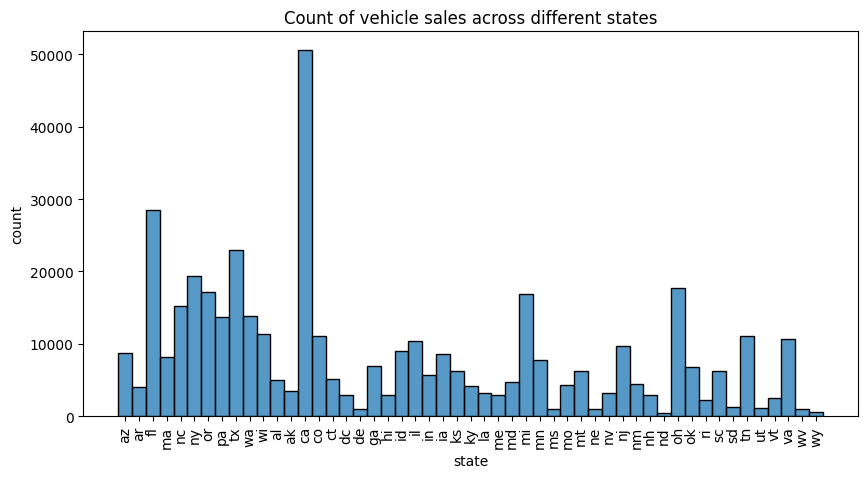

In [13]:
# visualize car sales by state
plt.figure(figsize=(10,5))
fig  = sns.histplot(data=raw_df['state'])
fig.set(xlabel='state', ylabel='count')
plt.tick_params(axis='x', rotation=90)
plt.title("Count of vehicle sales across different states")
plt.show()

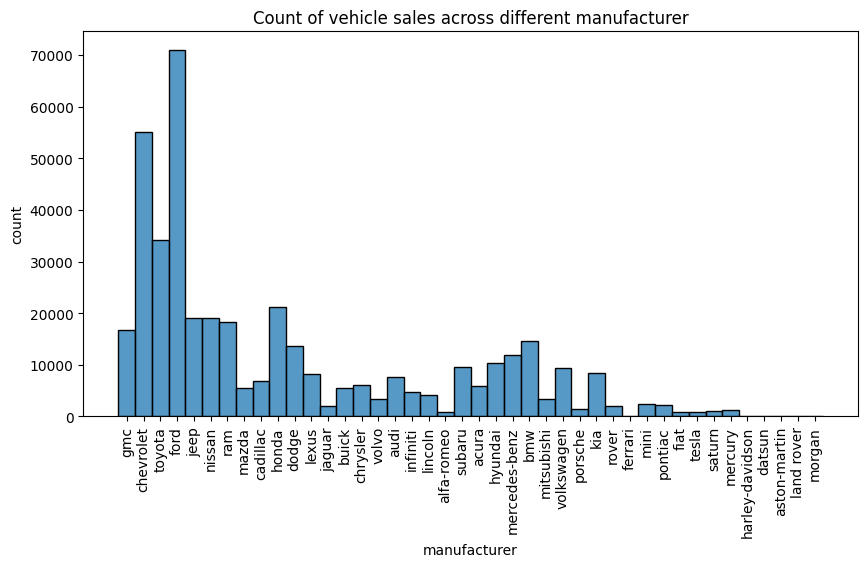

In [14]:
# visualize car sales by manufacturer
plt.figure(figsize=(10,5))
fig  = sns.histplot(data=raw_df['manufacturer'])
fig.set(xlabel='manufacturer', ylabel='count')
plt.tick_params(axis='x', rotation=90)
plt.title("Count of vehicle sales across different manufacturer")
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:499: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/usr/local/lib/python3.10/dist-packages/seaborn/distributions.py:500: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),


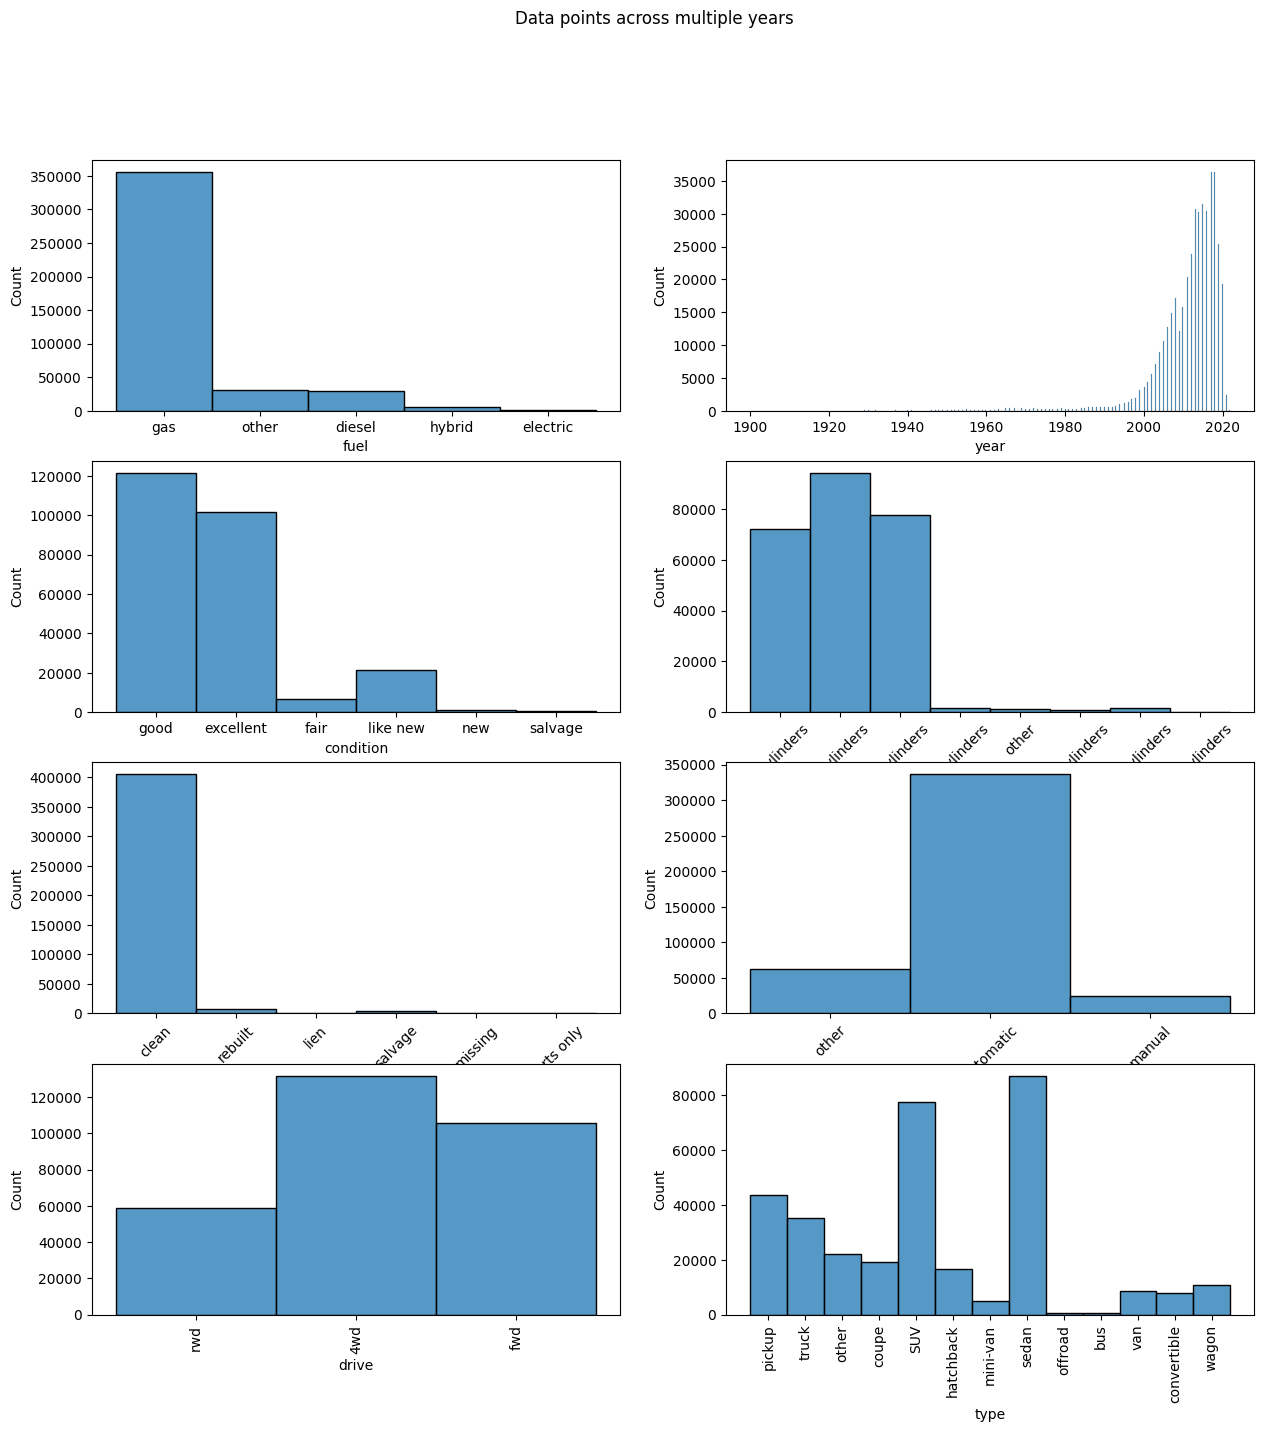

In [15]:
# explore distribution of data across multiple attributes

fig, axes = plt.subplots(4, 2, figsize=(15, 15))

fig.suptitle("Data points across multiple years")

plt.xticks(rotation=45)
sns.histplot(ax=axes[0, 0], data=raw_df, x='fuel')
axes[3, 1].tick_params(axis='x', rotation=45)
sns.histplot(ax=axes[0, 1], data=raw_df, x='year')
sns.histplot(ax=axes[1, 0], data=raw_df, x='condition')
axes[1, 1].tick_params(axis='x', rotation=45)
sns.histplot(ax=axes[1, 1], data=raw_df, x='cylinders')
axes[1, 1].tick_params(axis='x', rotation=45)
sns.histplot(ax=axes[2, 0], data=raw_df, x='title_status')
axes[2, 0].tick_params(axis='x', rotation=45)
sns.histplot(ax=axes[2, 1], data=raw_df, x='transmission')
axes[2, 1].tick_params(axis='x', rotation=45)
sns.histplot(ax=axes[3, 0], data=raw_df, x='drive')
axes[3, 0].tick_params(axis='x', rotation=90)
sns.histplot(ax=axes[3, 1], data=raw_df, x='type')
axes[3, 1].tick_params(axis='x', rotation=90)

plt.show()

<ipython-input-16-816edd2d8b73>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(raw_df.corr(), annot=True)


<Axes: >

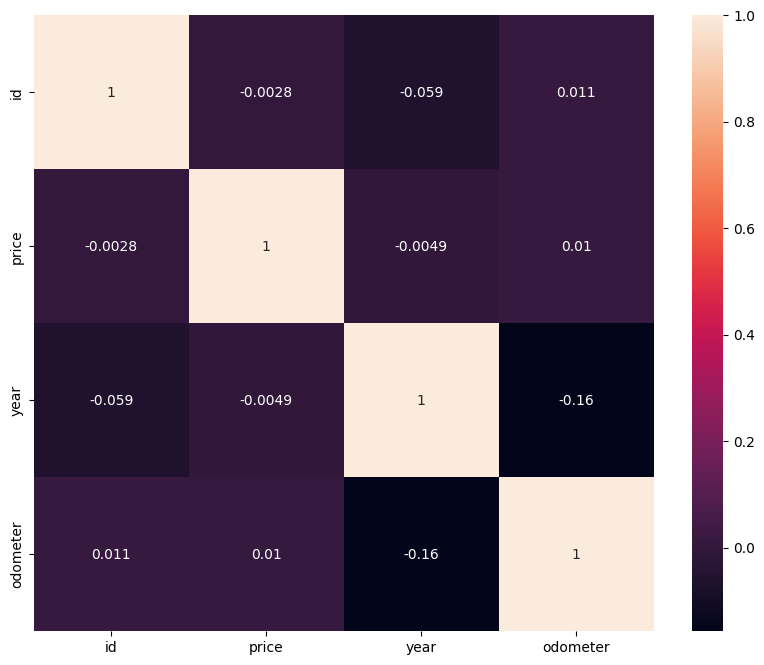

In [16]:
# plot the correlation between the numerical features
fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(raw_df.corr(), annot=True)

From the above exploratory analysis a few conclusion we can draw are

*   Dataset has columns that needs to be removed.
*   Dataset has columns with missing values and a strategy needs to be devised to deal with the missing values, some columns can be dropped while for other we need to impute the values.
*   Due to the quality of data, none of the numerical features seems to be strongly correlated to price.



### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

Remove the column that do would not impact the prediction quality due to either being highly null or being identifiers for the rows.

In [17]:
raw_df.drop(columns=['id','VIN','size'], inplace=True)

In [18]:
raw_df.shape

(426880, 15)

There are still rows where some of the critical features manufacturer, year and odometer are none. We will remove these rows.

In [19]:
# we will only take the rows where some of the important features like manufacturer, year and odometer is not NA.
# this reduced the rows to 426K to 405K or about 5% of data which should not alter the predictions significantly.
raw_df = raw_df[raw_df['manufacturer'].notna() & raw_df['year'].notna() & raw_df['odometer'].notna()].copy()

raw_df.shape

(405077, 15)

In [20]:
# Attempt to clean the model column to explore if the cardinality can be reduced for this column
raw_df['model_simple'] = raw_df['model'].str.replace('crew', '').str.replace('cab','').str.replace('sedan','').str.replace('suv','').str.replace('4d','').str.replace('2d','').str.replace('4x4','').str.replace('-','').str.replace('4wd','').str.replace('awd','')

raw_df

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,model_simple
27,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,<NA>,pickup,white,al,sierra 1500 slt
28,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,<NA>,pickup,blue,al,silverado 1500
29,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,<NA>,pickup,red,al,silverado 1500
30,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,<NA>,pickup,red,al,tundra double sr
31,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,f150 xlt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,wyoming,23590,2019,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226,clean,other,fwd,sedan,<NA>,wy,maxima s
426876,wyoming,30590,2020,volvo,s60 t5 momentum sedan 4d,good,<NA>,gas,12029,clean,other,fwd,sedan,red,wy,s60 t5 momentum
426877,wyoming,34990,2020,cadillac,xt4 sport suv 4d,good,<NA>,diesel,4174,clean,other,<NA>,hatchback,white,wy,xt4 sport
426878,wyoming,28990,2018,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112,clean,other,fwd,sedan,silver,wy,es 350


In [21]:
# create a function that can lexicographically sort the different words in model
def sort_string(x):
    try:
        token = x.split(' ')
        return ' '.join(sorted(token)).strip().lower()
    except:
        return ''
raw_df['model_simple'] = raw_df['model_simple'].apply(sort_string)

# cadinality of this feature is still very high(>19K) and hence will drop this feature.
raw_df['model_simple'].nunique()

19200

Looking at the model column, there are some keywords in the string like 4x4,4wd, 2wd etc that can be used to fill missing values for drive column.

In [22]:
raw_df2 = raw_df.copy()
def add_drive(x):
    try:
        if ('4x4' in x) or ('4wd' in x) or ('awd' in x):
            return '4wd'
        elif ('fwd' in x) or ('2wd' in x) or ('4x2' in x):
            return 'fwd'
        elif ('rwd' in x):
            return 'rwd'
    except:
        pass

raw_df2['drive'] = raw_df2[raw_df2['drive'].isna()].apply(lambda row : add_drive(row['model']), axis=1)
raw_df2['drive'].value_counts()

4wd    4428
fwd     260
rwd      43
Name: drive, dtype: int64

From the above exercise we have been able to add 4.7K missing entries to the data.

In [23]:
# Add the missing values to the drive column
raw_df['drive'] = np.where(raw_df['drive'].isna(), raw_df2['drive'], raw_df['drive'])

In [24]:
raw_df['drive'].value_counts()

4wd    132912
fwd    101393
rwd     53699
Name: drive, dtype: int64

Let us convert the column cylinders to numeric. Where the cylinder count is other we will also convert it to NA.

In [25]:
# convert the column cylendar to int remove other type
raw_df['cylinders'] = raw_df['cylinders'].str.replace(" cylinders","")
raw_df['cylinders'] = raw_df['cylinders'].replace('other', np.nan)
raw_df['cylinders'] = raw_df['cylinders'].astype('Int64')
raw_df['cylinders'].value_counts(dropna=False)

<NA>    167952
6        90307
4        74326
8        68906
5         1564
10        1352
3          553
12         117
Name: cylinders, dtype: Int64

We will use an imputer to determine the potential values for the missing rows for cylinder column.

We will conver the column year to age. The most recent record in the dataset is from 2022 and we will assume that the current year is 2022. The oldest year in the dataset is 1900.

In [26]:
# add a new column age which is year(2022) - year
raw_df['age'] = (2022 - raw_df['year'])

In [27]:
# look at the 99.9% value for the existing numerical features.
raw_df.describe([.999])

,price,year,cylinders,odometer,age
count,405077.0,405077.0,237125.0,405077.0,405077.0
mean,77688.670919,2011.500335,5.966461,96773.459967,10.499665
std,12502819.84991,8.943412,1.597374,200546.033549,8.943412
min,0.0,1900.0,3.0,0.0,0.0
50%,13995.0,2014.0,6.0,85880.0,8.0
99.9%,105000.0,2021.0,10.0,1111111.0,88.0
max,3736928711.0,2022.0,12.0,10000000.0,122.0


From the above p99.9 the price is > 105K, Odometer reading > 1.1M and age is 88 year. We will drop the rows having the values larger than these values to remove outliers from the datset. Removing the rows brings down the count from 405077 to 403974, which is less than 1% of rows so it should not impact the prediction quality.

In [28]:
# lets get p999 values and filter the rows where the value for price, odometer and age are greater than the p999 values.
# This reduces the row count from 405077 to 403974 so we did not loose a lot of data points.
p999_array = raw_df.describe([.999])

print('removing entries with price >'+str(p999_array['price'][5]) + ', odometer > '+ str(p999_array['odometer'][5])+' and older than '+str(p999_array['age'][5]))

raw_df = raw_df[(raw_df['price'] <= p999_array['price'][5]) & (raw_df['odometer'] <= p999_array['odometer'][5]) & (raw_df['age'] <= p999_array['age'][5])]

removing entries with price >105000.0, odometer > 1111111.0 and older than 88.0


In [29]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403974 entries, 27 to 426879
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        403974 non-null  string
 1   price         403974 non-null  Int64 
 2   year          403974 non-null  Int64 
 3   manufacturer  403974 non-null  string
 4   model         398943 non-null  string
 5   condition     239397 non-null  string
 6   cylinders     236442 non-null  Int64 
 7   fuel          401967 non-null  string
 8   odometer      403974 non-null  Int64 
 9   title_status  396770 non-null  string
 10  transmission  402354 non-null  string
 11  drive         287375 non-null  object
 12  type          318871 non-null  string
 13  paint_color   282173 non-null  string
 14  state         403974 non-null  string
 15  model_simple  403974 non-null  object
 16  age           403974 non-null  Int64 
dtypes: Int64(5), object(2), string(10)
memory usage: 57.4+ MB


Moving forward with the analysis, let us drop the column model and model_simple. We will using an imputer to generate the values for the missing features.

In [30]:
# looking at distinct values across all the columns we can drop the column model and model_simple.
# change drive column None to NA
# chage price 0 to NA
# convert to categorical for cylinders(<NA>), condition(<NA>), paint_color(<NA>), drive(None), type(<NA>), title_status(<NA>), fuel(<NA>), transmission(<NA>)

raw_df.select_dtypes(include='string').nunique()
raw_df_select = raw_df.drop(['model', 'model_simple','year'], axis=1)
raw_df_select['drive'] = np.where(raw_df_select['drive'] == 'None', np.NaN, raw_df_select['drive'])

# we set the price to Na
#raw_df_select['price'] = np.where(raw_df_select['price'] == 0, np.NaN, raw_df_select['price'])
raw_df_price_gt_zero=raw_df_select[raw_df_select['price'] > 0].copy()
raw_df_price_zero = raw_df_select[raw_df_select['price'] == 0].copy()

In [31]:
# mean price for the cars where the price is greater than 0
raw_df_price_gt_zero['price'].mean()

18736.265262477773

To use an imputer we want to convert categorial features to numeric. There are different encoders available for this. However I am using JamesSteinEncoder.

The approach we will be using here is to create a pipeline and use fit_transform to generate numerical values for the different categorical features using price as the predicted value. As there are rows where the price is 0, so we fit the pipeline using the rows where price > 0 and then make use that encoder pipeline to generate the encodings for the rows where the price is 0.

We also configure the encoder to retun nan for the rows where the column is missing the value.

In [32]:
# encode drive, cylinders, condition, paint_color, type, title_status, fuel, transmission
encoder_pipe = Pipeline([('encoder_drive', ce.JamesSteinEncoder(cols=['drive'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_cylinders', ce.JamesSteinEncoder(cols=['cylinders'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_condition', ce.JamesSteinEncoder(cols=['condition'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_paint_color', ce.JamesSteinEncoder(cols=['paint_color'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_type', ce.JamesSteinEncoder(cols=['type'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_title_status', ce.JamesSteinEncoder(cols=['title_status'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_fuel', ce.JamesSteinEncoder(cols=['fuel'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_transmission', ce.JamesSteinEncoder(cols=['transmission'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_region', ce.JamesSteinEncoder(cols=['region'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_manufacturer', ce.JamesSteinEncoder(cols=['manufacturer'], handle_missing='return_nan', handle_unknown='return_nan')),
                 ('encoder_state', ce.JamesSteinEncoder(cols=['state'], handle_missing='return_nan', handle_unknown='return_nan')),
                ])

encoder_pipe

Pipeline(steps=[('encoder_drive',
                 JamesSteinEncoder(cols=['drive'], handle_missing='return_nan',
                                   handle_unknown='return_nan')),
                ('encoder_cylinders',
                 JamesSteinEncoder(cols=['cylinders'],
                                   handle_missing='return_nan',
                                   handle_unknown='return_nan')),
                ('encoder_condition',
                 JamesSteinEncoder(cols=['condition'],
                                   handle_missing='return_nan',
                                   handle_unknown='return_n...
                                   handle_unknown='return_nan')),
                ('encoder_region',
                 JamesSteinEncoder(cols=['region'], handle_missing='return_nan',
                                   handle_unknown='return_nan')),
                ('encoder_manufacturer',
                 JamesSteinEncoder(cols=['manufacturer'],
                                   handle_missing='return_nan',
                                   handle_unknown='return_nan')),
                ('encoder_state',
                 JamesSteinEncoder(cols=['state'], handle_missing='return_nan',
                                   handle_unknown='return_nan'))])

In [33]:
# encode both the datasets where the price is 0 and price >0 independently.

df2 = encoder_pipe.fit_transform(raw_df_price_gt_zero,raw_df_price_gt_zero['price'])
df3 = encoder_pipe.transform(raw_df_price_zero)

Merge the 2 datasets back, the resulting dataset should have the row count of 403974. Also none of the columns should be string any longer.

In [34]:
# Combine the 2 dataframes
merged_encoded = pd.concat([df2,df3])

# change the price to NA where the price is 0
merged_encoded['price'] = np.where(merged_encoded['price'] == 0, np.NaN, merged_encoded['price'])
merged_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403974 entries, 27 to 426868
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        403974 non-null  Float64
 1   price         374546 non-null  object 
 2   manufacturer  403974 non-null  Float64
 3   condition     239397 non-null  Float64
 4   cylinders     236442 non-null  Float64
 5   fuel          401967 non-null  Float64
 6   odometer      403974 non-null  Int64  
 7   title_status  396770 non-null  Float64
 8   transmission  402354 non-null  Float64
 9   drive         287375 non-null  Float64
 10  type          318871 non-null  Float64
 11  paint_color   282173 non-null  Float64
 12  state         403974 non-null  Float64
 13  age           403974 non-null  Int64  
dtypes: Float64(11), Int64(2), object(1)
memory usage: 51.2+ MB


After the encoding, null percent across the columns should not change.

<Figure size 1500x1000 with 0 Axes>

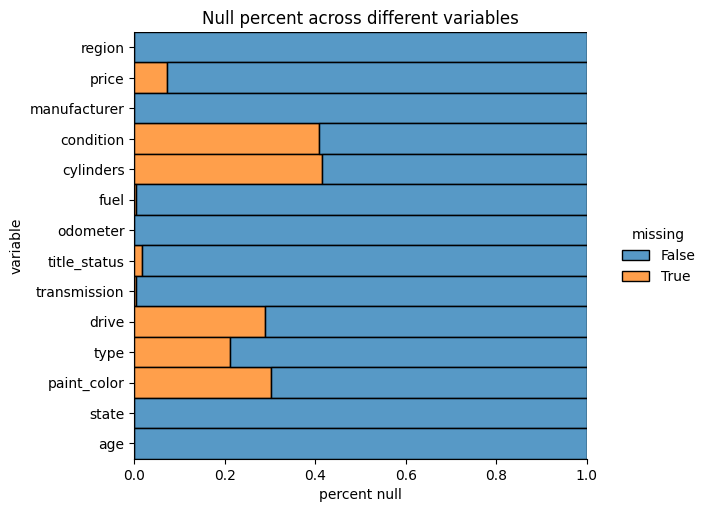

In [35]:
# print the na values across the different columns

plt.figure(figsize=(15,10))
fig = sns.displot(
    merged_encoded.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
fig.set(xlabel='percent null', ylabel='variable')
plt.title("Null percent across different variables")
plt.show()
#merged_encoded.isna().sum().sort_values(ascending=False)

Now we will use the KNNImputer to find the missing values across the different columns. We will use the nearest neighbors value of 1 for this analysis. As this step also takes a significant amount of time to run, we will save the output as knn_imputed_all.csv in one of the following steps.

In [36]:
# apply KNNImputer to find missing values.
# this step takes ~4hrs to run and generate
# Uncomment this code to rerun the code. This data is also saved in drive and is
# used below

#imputer = KNNImputer(n_neighbors=1)
#df3 = imputer.fit_transform(merged_encoded)

#imputed_df = pd.DataFrame(df3, columns = imputer.get_feature_names_out())
#imputed_df.to_csv('/content/drive/MyDrive/assignment 2/data/knn_imputed_all.csv')


Let us again look at the null percentage across the different columns to make sure that there are no more nulls

Read the imputed dataset from storage.

In [37]:
imputed_df = pd.read_csv('/content/drive/MyDrive/assignment 2/data/knn_imputed_all.csv')

We compare the mean price for all the rows before and after the imputation and see that the mean price has increases by < 1%

In [38]:
print("Mean price before: "+str(round(raw_df_price_gt_zero['price'].mean(),2)))
print("Mean price after: "+str(round(imputed_df['price'].mean(),2))+ " row count: "+str(imputed_df.shape[0]))

Mean price before: 18736.27
Mean price after: 18884.61 row count: 403974


Let us revisualize the null percentage to ensure there are no null values in the dataset.

<Figure size 1500x1000 with 0 Axes>

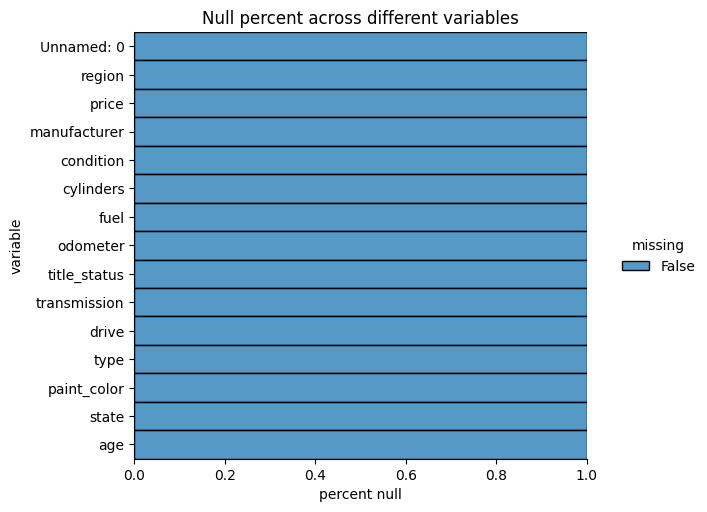

In [39]:
# print the na values across the different columns after imputation.

plt.figure(figsize=(15,10))
fig = sns.displot(
    imputed_df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
fig.set(xlabel='percent null', ylabel='variable')
plt.title("Null percent across different variables")
plt.show()


Summary of this section

*   We have cleaned the data and kept only the rows for which the values for price, year and odometer is <= .999 percentile of the original data.
*   We have JamesSteinEncoder to encode the categorical features.
*   We have imputed the null values to 1 nearest neighbor values using KNNImputer and saved the imputed values to knn_imputed_all.csv.
*   Post imputation we do not see any null values in the dataset and the mean price for the entire dataset has shifted by < 1%



### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Before starting with modelling, let us look at correlation between different variables.

<Axes: >

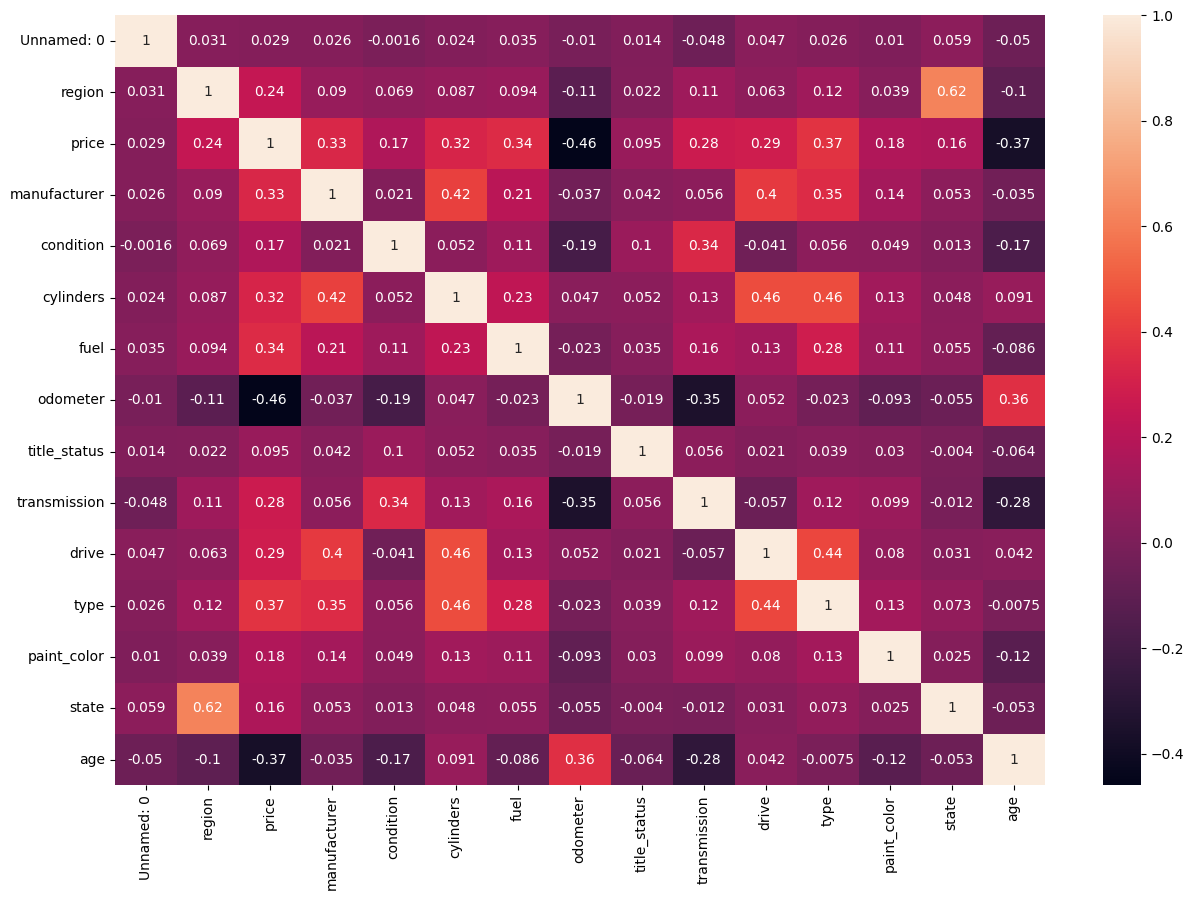

In [40]:
fig, ax = plt.subplots(figsize=(15,10))

sns.heatmap(imputed_df.corr(), annot=True)

From the above we can see that there are features that seem to have both positive and negative correlation. Some of the intial observations from the above analysis are


*   Price seems to have postive correlation with manufacturer, fuel, type, cylinders and region.
*   Price seems to have negative correlation with age and odometer. This is also a general observation that older vehicles or vehicles with more mileage tend to be cheaper than the other.



Before starting with the modelling exercise, split the dataset into train and test sets.

In [41]:
# create a dictionary to store data for the different modelling experiments
mae_dict = {}

In [42]:
# Split the dataset into train and validation set
X = imputed_df.drop('price', axis = 1)
y = imputed_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

To start with, we will train a linear regression model with standardized feature values.

In [43]:
# train a basic Linear Regression model and find the RMSE and MAE for the train/test set
lr_pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('linreg', LinearRegression())])
lr_pipe

lr_pipe.fit(X_train, y_train)

lr_train_rmse = mean_squared_error(y_train, lr_pipe.predict(X_train),squared=False)
y_pred = lr_pipe.predict(X_test)
lr_test_rmse = mean_squared_error(y_test, lr_pipe.predict(X_test), squared=False)
print(' RMSE for Linear Regression model for training data: {:0.2f}'.format(lr_train_rmse))
print(' RMSE for Linear Regression model on test data: {:0.2f}'.format(lr_test_rmse))

lr_train_mae = median_absolute_error(y_train, lr_pipe.predict(X_train))
lr_test_mae = median_absolute_error(y_test, lr_pipe.predict(X_test))

print(' MAE for Linear Regression model for training data: {:0.2f}'.format(lr_train_mae))
print(' MAE for Linear Regression model on test data: {:0.2f}'.format(lr_test_mae))

mae_dict['Linear Regression'] = {
    "training set": f"{lr_train_mae:.4f}",
    "testing set": f"{lr_test_mae:.4f}",
}

 RMSE for Linear Regression model for training data: 10129.19
 RMSE for Linear Regression model on test data: 10126.31
 MAE for Linear Regression model for training data: 4720.02
 MAE for Linear Regression model on test data: 4759.63


Let us plot the predicted vs actual values to visualize which measure is more approprite to measure errors from the model

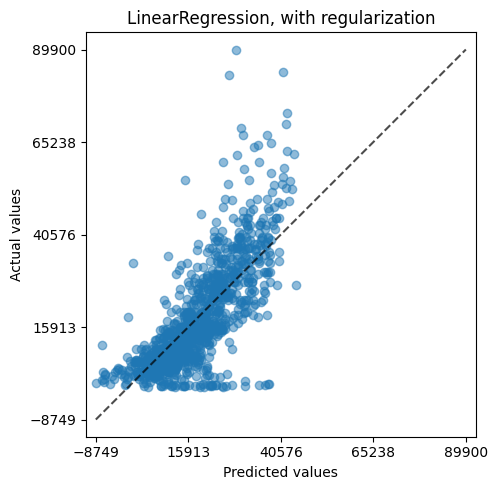

In [44]:
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("LinearRegression, with regularization")
plt.tight_layout()

From the above we do see that there are outliers. Hence I will be using Mean Absolute Error (also called the Average Absolute Deviation). RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a bell-shaped curve), the RMSE performs very well and is generally preferred.

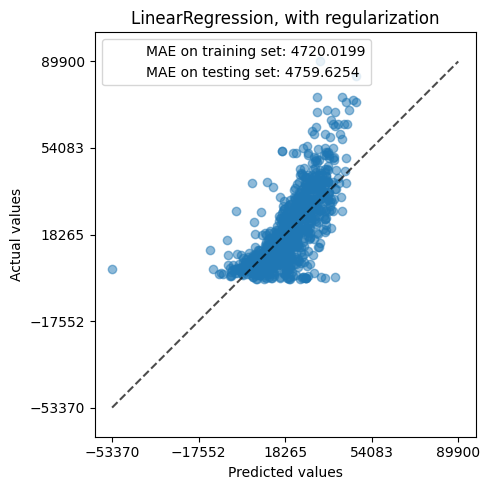

In [45]:
scores = {
    "MAE on training set": f"{lr_train_mae:.4f}",
    "MAE on testing set": f"{lr_test_mae:.4f}",
}
_, ax = plt.subplots(figsize=(5, 5))
display = PredictionErrorDisplay.from_predictions(
    y_test, y_pred, kind="actual_vs_predicted", ax=ax, scatter_kwargs={"alpha": 0.5}
)
ax.set_title("LinearRegression, with regularization")
for name, score in scores.items():
    ax.plot([], [], " ", label=f"{name}: {score}")
ax.legend(loc="upper left")
plt.tight_layout()

The next model I will train is Linear Regression with Polynomial features to explore if this can produce lower MAE than linear regression model.

In [46]:
# train a polynomial feature model with only the top 8 features based on correlation

features = ['odometer','age', 'type', 'fuel', 'manufacturer', 'cylinders','transmission','drive']

train_maes = []
test_maes = []
best_pipe = None
best_model_complexity = -1
lowest_model_mae = float('inf')
#for degree in 1 - 6
for i in range(1, 6):
    #create pipeline with PolynomialFeatures degree i
    poly_ordinal_ohe = make_column_transformer((PolynomialFeatures(degree = i,include_bias=False), make_column_selector(dtype_include=np.number)))
    pipe = Pipeline([
        ('transformer', poly_ordinal_ohe),
        ('linreg', LinearRegression())])

    pipe.fit(X_train[features], y_train)
    #fit on train
    p1 = median_absolute_error(y_train, pipe.predict(X_train[features]))
    p2 = median_absolute_error(y_test, pipe.predict(X_test[features]))
    if p2 < lowest_model_mae:
        lowest_model_mae = p2
        best_pipe = pipe
        best_model_complexity = i
    #predict on train and test
    train_maes.append(p1)
    test_maes.append(p2)

The Complexity that minimized Test Error was: 4


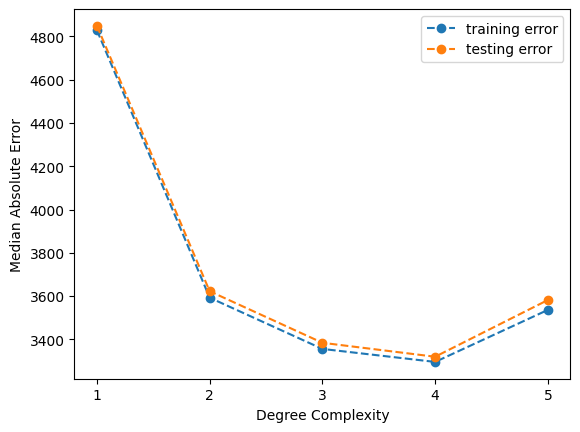

In [47]:
best_model_complexity = test_maes.index(min(test_maes)) + 1
print(f'The Complexity that minimized Test Error was: {test_maes.index(min(test_maes)) + 1}')
plt.plot(range(1, 6), train_maes, '--o', label = 'training error')
plt.plot(range(1, 6), test_maes, '--o', label = 'testing error')
plt.xticks(range(1, 6), range(1, 6))
plt.xlabel('Degree Complexity')
plt.ylabel('Median Absolute Error')
plt.legend();

mae_dict['Linear Regression, polynomial feature degree 4'] = {
    "training set": f"{min(test_maes):.4f}",
    "testing set": f"{min(test_maes):.4f}",
}

From the above analysis we can see that the MAE for the polynomial feature regression model is lowest for degree 6.

Explore Ridge model with an alpha of .01 with log scaled data

In [48]:
# train a ridge model
pipe_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge',TransformedTargetRegressor(
        regressor=Ridge(alpha=.01), func=np.log10, inverse_func=sp.special.exp10)),
])

pipe_ridge.fit(X_train, y_train)
train_mae = median_absolute_error(y_train, pipe_ridge.predict(X_train))
y_pred = pipe_ridge.predict(X_test)
test_mae = median_absolute_error(y_test, pipe_ridge.predict(X_test))
print(train_mae)
print(test_mae)

r = permutation_importance(pipe_ridge, X_test, y_test, n_repeats=30,random_state=42, scoring='neg_mean_absolute_percentage_error')

df = pd.DataFrame({'Feature': X_test.columns,
                              'Importance': r.importances_mean})

# Sort the DataFrame by importance values
df.sort_values(by='Importance', ascending=False, inplace=True)
print('Scoring Algorithm: neg_mean_absolute_percentage_error')
mae_dict['Ridge regressor'] = {
    "training set": f"{train_mae:.4f}",
    "testing set": f"{test_mae:.4f}",
}
df

4578.761457586666
4571.325772751286
Scoring Algorithm: neg_mean_absolute_percentage_error


,Feature,Importance
10,type,1.479636
3,condition,1.454350
5,fuel,1.420218
1,region,0.878985
13,age,0.335438
12,state,0.049203
7,title_status,0.004332
11,paint_color,-0.123084
0,Unnamed: 0,-0.414443
8,transmission,-0.578099


From the above we can see that Odometer and drive has the strongest importance among the features followed by vehicle type, condition and fuel type. The same can also be validated from the regressor coefficients below.

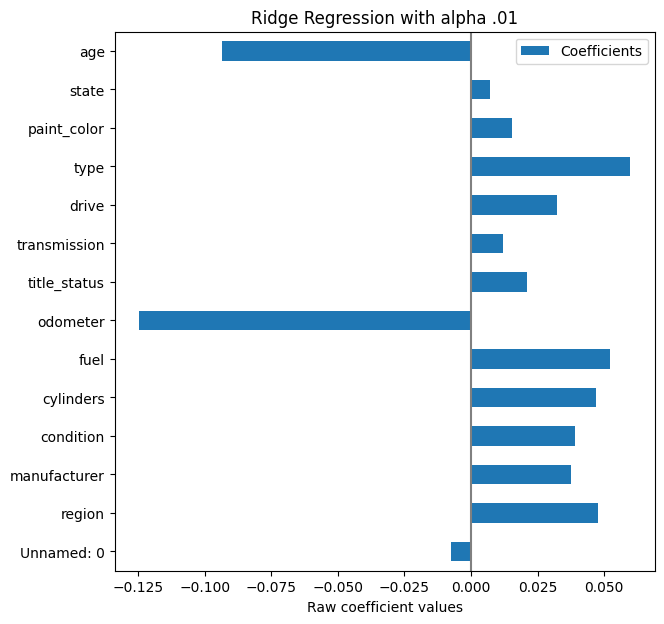

In [49]:
feature_names = X_train.columns

coefs = pd.DataFrame(
    pipe_ridge.named_steps['ridge'].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
plt.title("Ridge Regression with alpha .01")
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

Train a lasso model and compute MAE values for test and train set.

In [50]:
# Let's use the Lasso model
pipe_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('lasso',Lasso(random_state=42, alpha=.01))
])
pipe_lasso.fit(X_train, y_train)
train_mae = median_absolute_error(y_train, pipe_lasso.predict(X_train))
y_pred = pipe_lasso.predict(X_test)
test_mae = median_absolute_error(y_test, pipe_lasso.predict(X_test))
print(train_mae)
print(test_mae)

r = permutation_importance(pipe_lasso, X_test, y_test, n_repeats=30,random_state=42, scoring='neg_mean_absolute_percentage_error')

df = pd.DataFrame({'Feature': X_test.columns,
                              'Importance': r.importances_mean})

# Sort the DataFrame by importance values
df.sort_values(by='Importance', ascending=False, inplace=True)

mae_dict['Lasso'] = {
    "training set": f"{train_mae:.4f}",
    "testing set": f"{test_mae:.4f}",
}

4720.043372309159
4759.629454116584


Explore different selection of features and alpha values to identify which combination yields in lowest MAE for the split datasets

In [51]:
# use feature selector and grid search to fine
param_dict = {'selector__n_features_to_select':[4,6,8],'ridge__regressor__alpha': [.001,.1,100]}

pipe_selector_ridge = Pipeline([
    ('scaler', StandardScaler()),
    ('selector',SequentialFeatureSelector(estimator = Lasso())),
    ('ridge',TransformedTargetRegressor(
        regressor=Ridge(), func=np.log10, inverse_func=sp.special.exp10)),
])

selector_grid_ridge = GridSearchCV(estimator=pipe_selector_ridge, param_grid=param_dict)

selector_grid_ridge.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector',
                                        SequentialFeatureSelector(estimator=Lasso())),
                                       ('ridge',
                                        TransformedTargetRegressor(func=<ufunc 'log10'>,
                                                                   inverse_func=<ufunc 'exp10'>,
                                                                   regressor=Ridge()))]),
             param_grid={'ridge__regressor__alpha': [0.001, 0.1, 100],
                         'selector__n_features_to_select': [4, 6, 8]})

For the ridge regressor let us perform the feature importance to identify the features it deems are important to determing the prices of used cars.

In [52]:
train_mae = median_absolute_error(y_train, selector_grid_ridge.predict(X_train))
y_pred = selector_grid_ridge.predict(X_test)
test_mae = median_absolute_error(y_test, selector_grid_ridge.predict(X_test))
print("MAE training: " +str(train_mae))
print("MAE test: " +str(test_mae))

r = permutation_importance(selector_grid_ridge, X_test, y_test, n_repeats=30,random_state=42, scoring='neg_mean_absolute_percentage_error')

df = pd.DataFrame({'Feature': X_test.columns,
                              'Importance': r.importances_mean})

# Sort the DataFrame by importance values
selector_grid_ridge__alpha = selector_grid_ridge.best_estimator_.named_steps['ridge'].regressor_.alpha
selector_grid_ridge__nfeatures = selector_grid_ridge.best_estimator_.named_steps['selector'].n_features_to_select

df.sort_values(by='Importance', ascending=False, inplace=True)
ttl = "Ridge Regression with alpha "+str(selector_grid_ridge__alpha) +" feature count: "+str(selector_grid_ridge__nfeatures)
print(ttl)
df

MAE training: 4638.418607888687
MAE test: 4629.040838222107
Ridge Regression with alpha 0.001 feature count: 8


,Feature,Importance
5,fuel,1.699853
10,type,1.658617
1,region,1.072106
13,age,0.821771
0,Unnamed: 0,0.000000
3,condition,0.000000
7,title_status,0.000000
8,transmission,0.000000
11,paint_color,0.000000
12,state,0.000000


Let us check for the regressor coefficients to verify if these coefficients match the scale as seen from the importance of the features above.

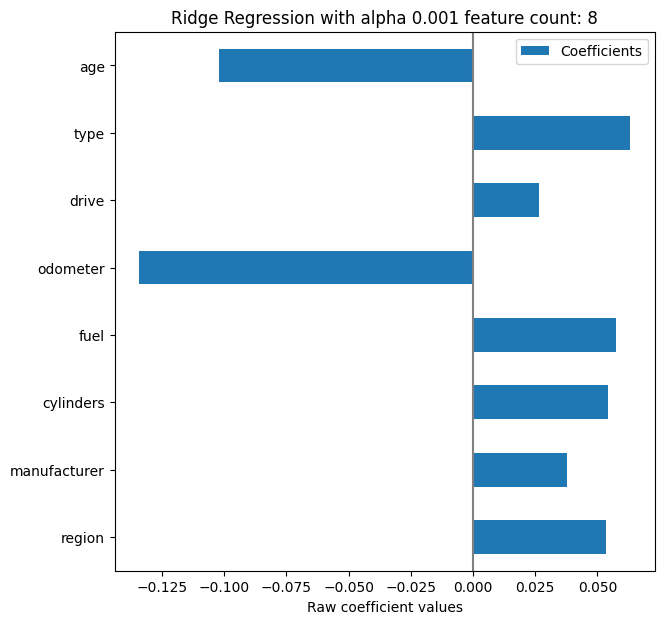

In [53]:
best_estimator = selector_grid_ridge.best_estimator_
feature_idx = best_estimator.named_steps['selector'].get_support()
feature_names = X_train.columns[feature_idx]

# add the features used by best estimator

coefs = pd.DataFrame(
    best_estimator.named_steps['ridge'].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
ttl = "Ridge Regression with alpha "+str(selector_grid_ridge__alpha) +" feature count: "+str(selector_grid_ridge__nfeatures)
plt.title(ttl)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)
mae_dict[ttl] = {
    "training set": f"{train_mae:.4f}",
    "testing set": f"{test_mae:.4f}",
}

The above image shows that the for odometer both the permutation importance and coefficient analaysis show has the highest impact. From feature importance the relative ordering for the other features is fuel, type, drive, cylinders, region, manufacturer and age.
While from coefficients it age is the second feature having the highest absolute value followed by type, fuel, region, cylinders, manufacturer and drive.

Let us train Lasso regressor model with feature selector and do a grid search to identify which features and what value for alpha can result in the best prediction model.

In [54]:
# train lasso model with feature selector
param_dict = {'selector__n_features_to_select':[4,6,8],'lasso__regressor__alpha': [.001,.1,100]}

pipe_selector_lasso = Pipeline([
    ('scaler', StandardScaler()),
    ('selector',SequentialFeatureSelector(estimator = Lasso())),
    ('lasso',TransformedTargetRegressor(
        regressor=Lasso(), func=np.log10, inverse_func=sp.special.exp10)),
])

selector_grid_lasso = GridSearchCV(estimator=pipe_selector_lasso, param_grid=param_dict)

selector_grid_lasso.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector',
                                        SequentialFeatureSelector(estimator=Lasso())),
                                       ('lasso',
                                        TransformedTargetRegressor(func=<ufunc 'log10'>,
                                                                   inverse_func=<ufunc 'exp10'>,
                                                                   regressor=Lasso()))]),
             param_grid={'lasso__regressor__alpha': [0.001, 0.1, 100],
                         'selector__n_features_to_select': [4, 6, 8]})

In [55]:
train_mae = median_absolute_error(y_train, selector_grid_lasso.predict(X_train))
test_mae = median_absolute_error(y_test, selector_grid_lasso.predict(X_test))
print("MAE training: " +str(train_mae))
print("MAE test: " +str(test_mae))

r = permutation_importance(selector_grid_lasso, X_test, y_test, n_repeats=30,random_state=42, scoring='neg_mean_absolute_percentage_error')

df = pd.DataFrame({'Feature': X_test.columns,
                              'Importance': r.importances_mean})

selector_grid_lasso__alpha = selector_grid_lasso.best_estimator_.named_steps['lasso'].regressor_.alpha
selector_grid_lasso__nfeatures = selector_grid_lasso.best_estimator_.named_steps['selector'].n_features_to_select

# Sort the DataFrame by importance values
df.sort_values(by='Importance', ascending=False, inplace=True)
ttl = "Lasso Regression with alpha "+str(selector_grid_lasso__alpha) + ' feature count: '+str(selector_grid_lasso__nfeatures)
print(ttl)
mae_dict[ttl] = {
    "training set": f"{train_mae:.4f}",
    "testing set": f"{test_mae:.4f}",
}
df

MAE training: 4642.935574377907
MAE test: 4637.170536168258
Lasso Regression with alpha 0.001 feature count: 8


,Feature,Importance
5,fuel,1.682560
10,type,1.660099
1,region,1.057015
13,age,0.823484
0,Unnamed: 0,0.000000
3,condition,0.000000
7,title_status,0.000000
8,transmission,0.000000
11,paint_color,0.000000
12,state,0.000000


Feature importance from the lasso models point to a relative importance of odometer, fuel type, vehicle type, drive, cylinders, region, manufacturer and age. Let us see what the model coefficients for these features are .



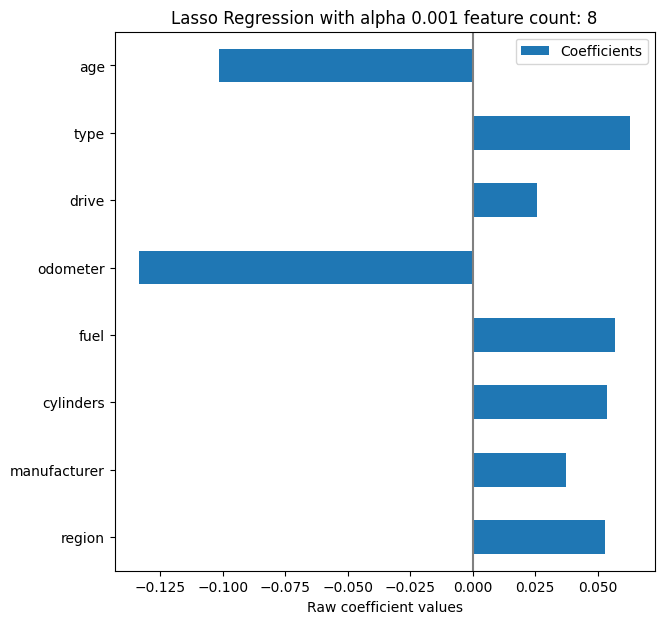

In [56]:
best_estimator = selector_grid_lasso.best_estimator_
feature_idx = best_estimator.named_steps['selector'].get_support()
feature_names = X_train.columns[feature_idx]


coefs = pd.DataFrame(
    best_estimator.named_steps['lasso'].regressor_.coef_,
    columns=["Coefficients"],
    index=feature_names,
)

coefs.plot.barh(figsize=(9, 7))
ttl = "Lasso Regression with alpha "+str(selector_grid_lasso__alpha) + ' feature count: '+str(selector_grid_lasso__nfeatures)
plt.title(ttl)
plt.axvline(x=0, color=".5")
plt.xlabel("Raw coefficient values")
plt.subplots_adjust(left=0.3)

As with Ridge regressor, the coefficients for Lasso regressor also seem to show that relative weight of coefficients follow the order odometer, age, type, fuel, region, manufacturer, cylinders and drive.

Summary of this section
*   We trained 6 different models including some with Grid search cross validation
*   We are using Median Absolute Error(MAE) to measure the error on test set from the different models as there are outliers and other error computation strategies seem to be less relevant.
*   We did permutation importance across multiple models to understand which features impact the prediction the most and also compared the feature importance with the coefficients for these features for the best models as reported from Grid search.   



In [57]:
print(mae_dict)

{'Linear Regression': {'training set': '4720.0199', 'testing set': '4759.6254'}, 'Linear Regression, polynomial feature degree 4': {'training set': '3319.6531', 'testing set': '3319.6531'}, 'Ridge regressor': {'training set': '4578.7615', 'testing set': '4571.3258'}, 'Lasso': {'training set': '4720.0434', 'testing set': '4759.6295'}, 'Ridge Regression with alpha 0.001 feature count: 8': {'training set': '4638.4186', 'testing set': '4629.0408'}, 'Lasso Regression with alpha 0.001 feature count: 8': {'training set': '4642.9356', 'testing set': '4637.1705'}}


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

From the above different modeling attempts, we have found that Linear Regression, polynomial feature degree 6 has the lowest Median Absolute Error(MAE) of 3537.9110 for training and 3537.9110 for test dataset.

From the feature importance perspective the general relative order using feature selection techniques seems to point to a relative order of odometer, fuel type, vehicle type, drive type, cylinders, region, manufacturer and age

There are 2 potential places that can be revisited.


*   We have used JamesSteinEncoder to encode the categorical features, we can also explore other encoders like TargetEncoders to explore if the MAE changes for some of the models.
*   The provided dataset had several missing values for condition, cylinder, drive and type (for some it was >25%) we can explore if there is a way to get values for these columns or attempt an alternative Imputer and compare the MAE values.
*.  For some of the important features like fuel, the data had larger number for gas vehicles than others and for some like Electric the difference in proportion of rows is very significant. We should try to get approximately even sized data for the different categorical features to avoid bias in the models.



In [58]:
pd.DataFrame.from_dict(mae_dict)

,Linear Regression,"Linear Regression, polynomial feature degree 4",Ridge regressor,Lasso,Ridge Regression with alpha 0.001 feature count: 8,Lasso Regression with alpha 0.001 feature count: 8
training set,4720.0199,3319.6531,4578.7615,4720.0434,4638.4186,4642.9356
testing set,4759.6254,3319.6531,4571.3258,4759.6295,4629.0408,4637.1705


Relative ordering based on MAE for the different Models on test dataset is

*   Linear Regression, polynomial feature degree 6 (Best)
*   Ridge regressor
*   Ridge Regression with alpha 0.001 feature count: 8
*   Lasso Regression with alpha 0.001 feature count: 8
*   Linear Regression
*   Lasso (Least)




### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

There are several factors that determine the price of a used car.

*   Mileage of the car influences the price of the car the most. So if given a choice between 2 cars a consumer is going to prefer cars that are driven less and hence you can sell low mileage cars for a better profit.
*   Fuel type of the cars also influence the price of the car. Gasoline cars seems to be by far the most selected option in used car market.
*   Type of the car(Sedan, SUV, Pickup etc) also impact the price of the cars. There however maybe a regional impact on the type of the car a consumer might decide to purchase. This is also evident from the fact that region a car is sold in has a positive correlation to the price of the car.
*   Vehicles with bigger enginer tend to negatively influence the price of the car. Hence in used car market people are looking for more fuel efficient vehicles.
*   Manufacturer of the car also influences the price of the car, hence there are manufacturers whose cars are more popular among the buyers than the others.
*   As is the known fact age of the car(or the year the car was manufactured) also influences the price of the car. However compared to other factors age has little impact on the price of the car i.e a car with less mileage but older might sell for a higher price than a more recent car with higher mileage.    


Disclaimer:-
 These observations are drived from looking at a used car sale data of around 403K cars and hence should be used with caution while making decisions on pricing a car. Some seemingly critical features like condition, drive, cylinders have missing data and machine learning technique has been used to impute those values which might not always represent the real values for those attributes that ultimately resulted in the car selling at a given price.  





